# Implementación de Algoritmo Genético y Memético para solución del TSP mediante un entorno distribuido


In [1]:
import numpy as np
import random
import os
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [2]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/home/dum/spark-3.1.2-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("Clase").setMaster("local[*]")
sc = SparkContext(conf = conf)

21/12/08 12:34:38 WARN Utils: Your hostname, dum-ThinkPad-T440p resolves to a loopback address: 127.0.1.1; using 192.168.15.25 instead (on interface wlp3s0)
21/12/08 12:34:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/12/08 12:34:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [139]:
conf.getAll()

dict_items([('spark.app.name', 'Clase'), ('spark.master', 'local[*]')])

In [140]:
sc._jsc.sc().uiWebUrl().get()

'http://192.168.15.25:4040'

# Definición de Parámetros

In [3]:
# Número de ciudades
N = 20
b = np.random.randint(1,100,size=(N,N))
# Generación de matriz de distancias al azar
mat_distancias = (b + b.T)/2
np.fill_diagonal(mat_distancias, 0)
# Tamaño de la población inicial
tam_pob_inicial = 100000

# Semilla

#np.random.seed(2013)
np.random.seed(13)


# Definición de Funciones Secuenciales

In [4]:
def TravellingSalesmanProblemSeq(datos_iniciales,tam_pob_inicial, prob_cruza, prob_muta,n_iter,pob_inicial ):
    best_dist = [] # Para guardar el fitness del mejor gen
    # HACEMOS LAS ITERACIONES PARA NUESTRO MODELO GENÉTICO
    for iter in range(n_iter):
        pool = [] # Para guardar la siguiente generación
        # RECORREMOS TODA LA POBLACIÓN INICIAL
        for i in range(tam_pob_inicial):
            hijo_gen=np.repeat(0,N) # Donde se va a guardar el hijo 
            # PROBABILIDAD PARA ENTRAR A LA CRUZA
            if (np.random.random()<prob_cruza): # Si entra para la cruza
                # Obtenemos un lista de los elementos sin el gen que vamos a cruzar
                pob_sin_i = list(np.delete(range(tam_pob_inicial),i)) 
                # La pareja del gen que vamos a cruzar
                gen_pareja = random.sample(pob_sin_i,1)[0] 
                # Cantidad de elementos del gen que se va a pasar a la siguiente generación
                cant_cruza = int(np.ceil(N/3)) 
                # Posición de inicio de los elementos que se van a copiar
                pos_ini_gen = int(np.random.randint(0,N-cant_cruza)) 
                # Elementos que se van a pasar al gen padre 1 al hijo
                elem_gen_pasa = pob_inicial[i][pos_ini_gen:(pos_ini_gen+cant_cruza)]
                # Agregando los elementos del gen del padre 1 adentro del hijo
                hijo_gen[pos_ini_gen:(pos_ini_gen+cant_cruza) ] = elem_gen_pasa 
                # Elementos del padre 2 sin los elementos del padre 1 que se van a pasar al hijo
                pareja_sin_elem_gen = np.setdiff1d(pob_inicial[gen_pareja],elem_gen_pasa,assume_unique=True)
                # Movemos todos los ceros al final del hijo para sustituir los elementos del padre 2 de manera más sencilla
                hijo_gen=np.roll(hijo_gen,-pos_ini_gen)
                # Aquí reemplazamos los ceros por los genes del padre en ese orden  
                hijo_gen[(N-len(pareja_sin_elem_gen)):]=pareja_sin_elem_gen 
                # Regresamos a la posición original
                hijo_gen=np.roll(hijo_gen,pos_ini_gen)
            # DE OTRA MENERA SE GUARDA EL GEN PADRE
            else:
                hijo_gen=np.array(pob_inicial[i])
            # PROBABILIDAD PARA ENTRAR A LA MUTA
            if (np.random.random()<prob_muta):
                elem_mutan=random.sample(range(N),2) # Elejimos 2 elementos 
                # Hacemos el intercambio de los elementos
                aux=hijo_gen[elem_mutan[0]] # Hacemos un aux para no cambiar el original
                hijo_gen[elem_mutan[0]]=hijo_gen[elem_mutan[1]]
                hijo_gen[elem_mutan[1]]=aux
            # Agregamos el gen hijo al pool
            pool.append(tuple(hijo_gen))
    
        # Unimos los gen de la generación anterior con la generación nueva 
        pob_total = np.array(list(pob_inicial) + list(pool))
        # Vector para guardar el fitness de cada uno de los elementos 
        fitness = []
        # SACAMOS EL FITNESS PARA TODOS LOS ELEMENTOS
        for gen in pob_total:
            fitness.append(recorrido(gen, datos_iniciales))
        # Ordemaos la población inicial respecto al fitness
        # ordenamos de menor a mayor
        pob_total_sorted = pob_total[np.argsort(fitness)]
        # Obtenemos los mejor tam_pob_inicial elementos
        pob_inicial = pob_total_sorted[0:tam_pob_inicial] 
        # Guardamos el fitness 
        best_dist.append(recorrido(pob_inicial[0], datos_iniciales))
    return(pob_inicial) # Regresamos el fitness

# Definición de funciones paralelas PySpark

In [5]:
def pob_inicial_paralelizacion(tam_pob_inicial, mat_distancias):
    # Definimos el tamaño de los cromosomas
    N = mat_distancias.shape[1]
    # calculamos el número máximo de cromosomas que existen
    if np.math.factorial(N)<tam_pob_inicial:
        print("error:el tamaño de tu poblacion inicial no puede ser más grande que el número total de soluciones distintas")
    #hacemos un array que contenga los índices de las ciudades
    ciudades = np.array(range(1,N+1)) 
    # Establecemos tres particiones para hacer la paralelización 
    dat_paralel = sc.parallelize([(1,int(np.floor(tam_pob_inicial/3))),(2, int(np.floor(tam_pob_inicial/3))), (3, tam_pob_inicial - 2*int(np.floor(tam_pob_inicial/3)))],3)
    # Definimos el mapper para que se genere la parte aleatoria
    def generar_parte_aleatoria(datos):
        parte = datos[0]
        datos_a_gen = datos[1]
        pob_inicial = []
        while len(pob_inicial) < datos_a_gen: 
            gen = tuple(np.random.permutation(range(1,N+1)))
            if not (gen in pob_inicial): 
                pob_inicial.append(gen) 
        return pob_inicial
    # Hacemos el map para generar las N/3 cromosomas que le corresponde a cada parte
    partes = dat_paralel.map(generar_parte_aleatoria).collect()
    #Unimos los resultados y quitamos los genes repetidos
    resultado_final = (np.unique(partes[0] + partes[1] + partes[2], axis = 1))
    # Revisamos que se tenga el tamaño solicitado para la pob inicial, si no es así generamos más cromosomas
    # para complementar a la pob iniical, revisando que no se encuentren ya en ésta
    if len(resultado_final) < tam_pob_inicial:
        gen = tuple(np.random.permutation(range(1,N+1))) 
        if not (gen in pob_inicial):
            np.append(resultado_final, gen, axis = 0)
    # regresamos la union de las poblaciones más los cromosomas que sustituyeron a cromosomas repetidos
    return resultado_final


In [141]:
# Funcion de evaluación o fitness
def recorrido(ruta, mat_distancias): 
    dist_total = 0   # Empezamos con un distancia de 0 que le vamos a ir añadiendo
    ruta = np.append(ruta, ruta[0]) # Agregamos la primer ciudad al final de la ruta 
    for i in range(len(ruta)-1): # Calculamos las distancias entre ciudades
        dist = mat_distancias[ruta[i]-1,ruta[i+1]-1]
        dist_total += dist # Sumamos las distancias
    return dist_total

# Funcion que regresa llave-valor, llave:gen y valor:distancia recorrida
def calc_fitness(gen, mat_datos):
    return list([recorrido(gen, mat_datos),gen])

# Funcion del algoritmo genético
def algo_genetico(dataset, prob_cruza, prob_muta, mat_dist):
    # DEFINICIÓN DE MAPPER DE LA CRUZA
    def cruza(pareja,prob_cruza):
        gen_padre1=pareja[0] # Tomamos el gen padre 1
        N=len(gen_padre1) # Tamaño del gen
        hijo_gen=np.repeat(0,N) # Donde se va a guardar el hijo 
        # PROBABILIDAD PARA ENTRAR A LA CRUZA
        if (np.random.random()<prob_cruza):
            gen_padre2=pareja[1] # Tomamos el gen padre 2
            # Cantidad de elementos del gen que se va a pasar a la siguiente generación
            cant_cruza = int(np.ceil(N/3)) 
            # Posición de inicio de los elementos que se van a copiar
            pos_ini_gen = int(np.random.randint(0,N-cant_cruza))
            # Elementos que se van a pasar al gen padre 1 al hijo
            elem_gen_pasa = gen_padre1[pos_ini_gen:(pos_ini_gen+cant_cruza)]
            # Agregando los elementos del gen del padre 1 adentro del hijo
            hijo_gen[pos_ini_gen:(pos_ini_gen+cant_cruza)] = elem_gen_pasa 
            # Elementos del padre 2 sin los elementos del padre 1 que se van a pasar al hijo
            pareja_sin_elem_gen = np.setdiff1d(gen_padre2,elem_gen_pasa,assume_unique=True)
            # Movemos todos los ceros al final del hijo para sustituir los elementos del padre 2 de manera más sencilla
            hijo_gen = np.roll(hijo_gen,-pos_ini_gen)
            # Aquí reemplazamos los ceros por los genes del padre en ese orden 
            hijo_gen[(N-len(pareja_sin_elem_gen)):] = pareja_sin_elem_gen
            # Regresamos a la posición original
            hijo_gen = np.roll(hijo_gen,pos_ini_gen)
        # DE OTRA MENERA SE GUARDA EL GEN PADRE
        else:
            hijo_gen=np.array(gen_padre1)
        # SE REGRESA EL HIJO GEN
        return hijo_gen
    # DEFINICIÓN DE MAPPER PARA LA MUTA
    def muta(hijo_gen,prob_muta):
        N=len(hijo_gen) # Tamaño del gen
        hijo_gen=np.array(hijo_gen) # Lo copiamos para poder modificarlo
        # PROBABILIDAD PARA ENTRAR A LA MUTA
        if (np.random.random()<prob_muta):
            # Elejimos 2 elementos 
            elem_mutan=random.sample(range(N),2)
            # Hacemos el intercambio de los elementos
            aux=hijo_gen[elem_mutan[0]] # Hacemos un aux para no cambiar el original
            hijo_gen[elem_mutan[0]]=hijo_gen[elem_mutan[1]]
            hijo_gen[elem_mutan[1]]=aux
        # SE REGRESA EL HIJO GEN
        return tuple(hijo_gen)
    # DEFINICIÓN MAPPER PARA REGRESAR EL PADRE 1
    def pob(pareja):
        return tuple(pareja[0])
    # Aplicamos el mapper de la cruza a los datos
    hijos = dataset.map(lambda pareja:cruza(pareja,prob_cruza))
    # Aplicamos el mapper de la cruza a los hijos que salieron de la cruza
    pool = hijos.map(lambda hijo:muta(hijo,prob_muta))
    # Obtenemos la población inicial
    pob_original = dataset.map(pob)
    # Los unimos (población padre e hijos) y sacamos los que son distintos
    pob_total = sc.union([pob_original, pool]).distinct() # Tomamos todas las diferentes
    # Obtenemos su fitness y ordenamos por llave (distancia recorrida)
    pob_total = pob_total.map(lambda gen:calc_fitness(gen,mat_dist)).sortByKey()
    return pob_total.values()

In [7]:
# Función para resolver el TSP
def algoritmo_genetico(pob_inicial,dist_ciudades,iter,prob_cruza, prob_muta,tam_pob_inicial):
    # HACEMOS LAS ITERACIONES PARA NUESTRO MODELO GENÉTICO
    for i in range(iter):
        # Obtenemos una muestra la población incial
        idx = np.random.randint(tam_pob_inicial, size=tam_pob_inicial) 
        # Tomamos esa muestra la población inicial
        random_pob_inicial=pob_inicial[idx,:]
        # Los pegamos en un array, es decir, ya desde un inicio van a tener a su pareja
        pob_inicial_par=[[pob_inicial[i],tuple(random_pob_inicial[i])]  for i in range(tam_pob_inicial)]
        # Lo pasamos al contexto de spark (Spark Context)
        pob_inicial_rdd = sc.parallelize(pob_inicial_par, 6)
        # Aplicamos el algoritmo genértico
        pob_inicial=algo_genetico(pob_inicial_rdd,prob_cruza, prob_muta,dist_ciudades)
        # Aplicamos Collect y tomamos los mejores tam_pob_inicial genes
        pob_inicial=np.array(pob_inicial.collect()[:tam_pob_inicial])
    return pob_inicial

In [234]:
def algo_memetico(dataset_rdd, num_busq_locales, mat_datos):
  def busqueda_local(gen, num_busq_locales):
    # obtenemos el tamaño del gen
    N = len(gen)
    # hacemos una copia del gen al que se le hará la busqueda local
    mejor_gen = np.array(gen)
    # calculamos el fitness del gen
    mejor_fitness = recorrido(mejor_gen, mat_datos)
    #hacemos un loop para realizar la búsqueda local el número de veces que se haya indicado
    for i in range(0,num_busq_locales):
      gen_mutado = np.copy(mejor_gen)
    # hacemos la búsqueda 2-opt
      elem_mutan=random.sample(range(N),2)
      aux=int(gen_mutado[elem_mutan[0]])
      gen_mutado[elem_mutan[0]] = gen_mutado[elem_mutan[1]]
      gen_mutado[elem_mutan[1]] = aux
    # calculamos el fitness del gen encontrado mediante la búsqueda
      fitness_gen_mutado = recorrido(gen_mutado, mat_datos)
        # si el fitness del gen encontrado es mejor, hacemos el intercambio
      if  fitness_gen_mutado < mejor_fitness:
        mejor_gen = gen_mutado
        mejor_fitness = fitness_gen_mutado
    
    # regresamos el mejor gen encontrado en la búsqueda local y su fitness 
    return(mejor_fitness, mejor_gen)
  
  mejor_crom = dataset_rdd.map(lambda gen : busqueda_local(gen, num_busq_locales)).sortByKey(True).collect()[0]
  return mejor_crom

# Generación de la población inicial

## Paralelo

In [138]:
%%time

pob_inicial = pob_inicial_paralelizacion(tam_pob_inicial, mat_distancias)


CPU times: user 837 ms, sys: 52.1 ms, total: 890 ms
Wall time: 1min 3s


## Secuencial

In [83]:
%%time
N = mat_distancias.shape[1] # Obtenemos el número de ciudades
if np.math.factorial(N)<tam_pob_inicial:
  print("error:el tamaño de tu poblacion inicial no puede ser más grande que el número total de soluciones distintas")
  # GENERANDO NUESTRA VECTOR PARA LA POBLACIÓN INICIAL
ciudades = np.array(range(1,N+1)) # Nombramos las ciudades del 1 al N
pob_inicial_seq = [] # Para guardar nuestros recorridos iniciales

  # GENERANDO LA POBLACIÓN INICIAL
while len(pob_inicial_seq) < tam_pob_inicial: # Para obtener exactamente la cantidad tam_pob_inicial
    gen = tuple(np.random.permutation(range(1,N+1))) # Obtenemos una permutación
    if not (gen in pob_inicial_seq): # Verificando si es diferente
        pob_inicial_seq.append(gen) # Lo agregamos si es diferente

CPU times: user 2.45 s, sys: 37.3 ms, total: 2.48 s
Wall time: 2.37 s


# Algoritmo Genético

## Paralelo

In [31]:
dataset_rdd = sc.parallelize(pob_inicial, 6)

In [125]:
%%time
resultado_genetico = algoritmo_genetico(pob_inicial,mat_distancias,5, 0.8, 0.2,tam_pob_inicial)

CPU times: user 395 ms, sys: 32.1 ms, total: 427 ms
Wall time: 3.11 s


In [34]:
print(resultado_genetico[0])
print(recorrido(resultado_genetico[0], mat_distancias))

[ 4 19 16  6  2  3  8 10  9 12 14 18  1 11 17  7  5 15 20 13]
667.5


## Secuencial

In [113]:
%%time 
pob_gen = np.copy(pob_inicial)
res_gen_seq = TravellingSalesmanProblemSeq(mat_distancias,tam_pob_inicial, 0.8, 0.2,10,pob_gen)

CPU times: user 2.22 s, sys: 0 ns, total: 2.22 s
Wall time: 2.22 s


In [114]:
print(res_gen_seq[0])
print(recorrido(res_gen_seq[0], mat_distancias))

[15  5  6 16 14 10  2 17  1 19  4 13  9 20 11 18  8  7  3 12]
628.5


# Algoritmo Memético

## Paralelo

In [126]:
res_gen_rdd = sc.parallelize(resultado_genetico, 20)

In [135]:
%%time
solucion = algo_memetico(res_gen_rdd, 100, mat_distancias)
print(solucion[1])
print(solucion[0])

[ 5  7  2  6 16 19  4 13  9 11 20 10 18  8  1 14 15 17  3 12]
483.5
CPU times: user 30.9 ms, sys: 4.09 ms, total: 35 ms
Wall time: 3.09 s


## Secuencial

In [136]:
%%time
res_gen = np.copy(resultado_genetico)
fitness = np.repeat(0,len(res_gen))
for index in range(len(res_gen)):
    # Tomamos el gen
    for iter in range(100):    
        gen_busqueda = np.array(res_gen[index])
        elem_mutan=random.sample(range(N),2) # Elejimos 2 elementos
        # Hacemos el intercambio de los elementos
        aux=int(gen_busqueda[elem_mutan[0]]) # Hacemos un aux para no cambiar el original
        gen_busqueda[elem_mutan[0]]=gen_busqueda[elem_mutan[1]]
        gen_busqueda[elem_mutan[1]]=aux
        # Obtenemos el fitness del gen modificado por la búsqueda local
        fit_gen_busq = recorrido(gen_busqueda, mat_distancias)
        fit_gen_original = recorrido(res_gen[index], mat_distancias)
        # Si es mejor el nuevo gen modifica, se intercambia
        if fit_gen_busq <= fit_gen_original:
            # Hacemos el intercambio del gen por el gen encontrado en la búsqueda local
            res_gen[index] = gen_busqueda
            fitness[index] = (fit_gen_busq)
        else:
            fitness[index] = (fit_gen_original)
    # Se vuelve a ordenar
res_mem_seq = res_gen[np.argsort(fitness)]
fitness = np.sort(fitness)
print(res_mem_seq[0])
print(fitness[0])

[ 2  6 16 19  4 14  7  5 12  3 18 10  9 13 11 20 15 17  1  8]
485
CPU times: user 4.67 s, sys: 4 ms, total: 4.67 s
Wall time: 4.67 s


# Gráficas de Evaluación

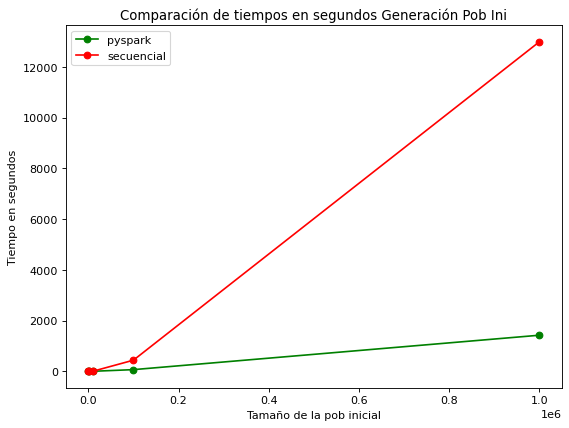

In [244]:
tam_pob_inicial = [100, 1000, 10000,100000,1000000]
tiempo_pyspark = [0.009, 0.085, 0.626, 66, 1422.1]
tiempo_secuencial = [0.004, 0.077, 2.37,438.6, 12986]
figure(figsize=(8, 6), dpi=80)
plt.plot(tam_pob_inicial, tiempo_pyspark,"o", color="green" ,linestyle="solid",label = "pyspark")
plt.plot(tam_pob_inicial, tiempo_secuencial,"o" ,color="red",linestyle="solid",label = "secuencial")
plt.legend()
plt.title("Comparación de tiempos en segundos Generación Pob Ini")
plt.xlabel('Tamaño de la pob inicial')
plt.ylabel('Tiempo en segundos')
plt.savefig('genpobini.png')
plt.show()


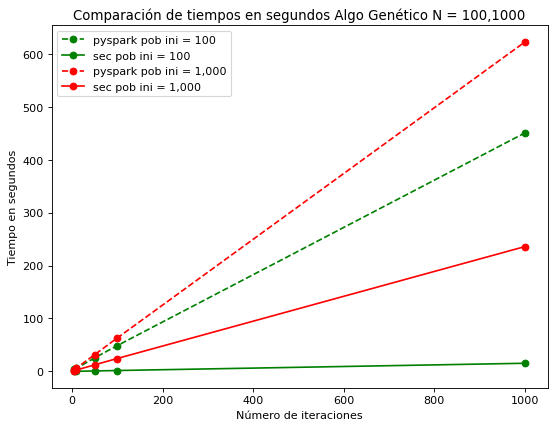

In [245]:
itera=[5,10,50,100,1000]
tiempo_pyspark_100 = [4.03,5.55,25.4, 48.6, 451]
tiempo_secuencial_100 = [.0967,.165,.77,1.58,15.3]
fitness_pyspark_100 = [631,595,503.5,432.5,424]
fitness_secuencial_100 =[654,606,477.5,430.5,427]


tiempo_pyspark_1000 = [3.16,6.28, 31.4,63, 623]
tiempo_secuencial_1000 = [1.22, 2.44, 12.3,24.3,236]
fitness_pyspark_1000 = [717, 661.5,554.5, 523, 507]
fitness_secuencial_1000 =[710, 638.5, 531, 516.5, 507]

figure(figsize=(8, 6), dpi=80)

plt.plot(itera, tiempo_pyspark_100,"o",color="green", linestyle='dashed', label = "pyspark pob ini = 100")
plt.plot(itera, tiempo_secuencial_100,"o",color="green",  linestyle="solid",label = "sec pob ini = 100")
plt.plot(itera, tiempo_pyspark_1000,"o",color="red", linestyle='dashed', label = "pyspark pob ini = 1,000")




plt.plot(itera, tiempo_secuencial_1000,"o",color="red",  linestyle="solid",label = "sec pob ini = 1,000")
plt.title("Comparación de tiempos en segundos Algo Genético N = 100,1000")
plt.xlabel('Número de iteraciones')
plt.ylabel('Tiempo en segundos')
plt.legend()

plt.savefig('genetico_100_1000.png')
plt.show()

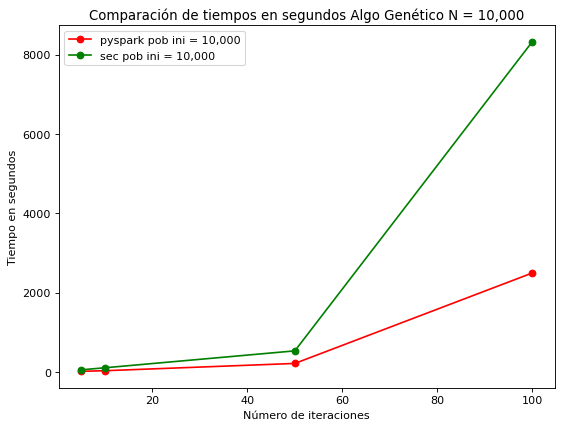

In [246]:
itera =[5,10,50,100]
tiempo_pyspark_10000 = [14.6,29.6,213,2492]
tiempo_secuencial_10000 = [52.6,104,530,8320]
fitness_pyspark = [643,584,466,432]
fitness_secuencial =[583,585,442,430]
figure(figsize=(8, 6), dpi=80)
plt.plot(itera, tiempo_pyspark_10000,"o",color="red", linestyle='solid', label = "pyspark pob ini = 10,000")



plt.plot(itera, tiempo_secuencial_10000,"o",color="green", linestyle="solid",label = "sec pob ini = 10,000")
plt.title("Comparación de tiempos en segundos Algo Genético N = 10,000")
plt.xlabel('Número de iteraciones')
plt.ylabel('Tiempo en segundos')
plt.legend()


plt.savefig('genetico_10000.png')
plt.show()

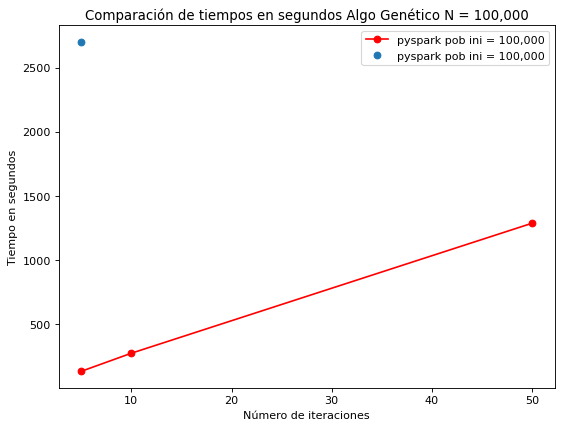

In [247]:
itera=[5,10,50]
tiempo_pyspark_100000 = [133,274,1287]
tiempo_secuencial_100000 = [2700]
fitness_pyspark_100000 = [650,603,458]
fitness_secuencial_100000 =[667]
figure(figsize=(8, 6), dpi=80)
plt.plot(itera, tiempo_pyspark_100000,"o",color="red", linestyle='solid',  label = "pyspark pob ini = 100,000")
plt.plot(5, tiempo_secuencial_100000, "o", label = "pyspark pob ini = 100,000")
plt.title("Comparación de tiempos en segundos Algo Genético N = 100,000")
plt.xlabel('Número de iteraciones')
plt.ylabel('Tiempo en segundos')
plt.legend()


plt.savefig('genetico_100000.png')
plt.show()

## fitness


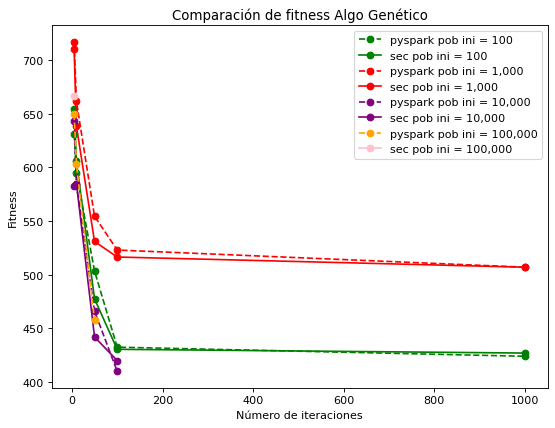

In [248]:
itera=[5,10,50,100,1000]
itera2=[5,10,50,100]
itera3=[5,10,50]
fitness_pyspark_100 = [631,595,503.5,432.5,424]
fitness_secuencial_100 =[654,606,477.5,430.5,427]
fitness_pyspark_1000 = [717, 661.5,554.5, 523, 507]
fitness_secuencial_1000 =[710, 638.5, 531, 516.5, 507]
fitness_pyspark_10000 = [643,584,466,410]
fitness_secuencial_10000 =[583,585,442, 420]


fitness_pyspark_100000 = [650,603,458]
fitness_secuencial_100000 =[667]
figure(figsize=(8, 6), dpi=80)
plt.plot(itera, fitness_pyspark_100,"o",color="green", linestyle='dashed', label = "pyspark pob ini = 100")
plt.plot(itera, fitness_secuencial_100,"o",color="green",  linestyle="solid",label = "sec pob ini = 100")
plt.plot(itera, fitness_pyspark_1000,"o",color="red", linestyle='dashed', label = "pyspark pob ini = 1,000")
plt.plot(itera, fitness_secuencial_1000,"o",color="red",  linestyle="solid",label = "sec pob ini = 1,000")

plt.plot(itera2, fitness_pyspark_10000,"o",color="purple", linestyle='dashed', label = "pyspark pob ini = 10,000")
plt.plot(itera2, fitness_secuencial_10000,"o",color="purple",  linestyle="solid",label = "sec pob ini = 10,000")

plt.plot(itera3, fitness_pyspark_100000,"o",color="orange", linestyle='dashed', label = "pyspark pob ini = 100,000")
plt.plot(5, fitness_secuencial_100000,"o",color="pink",  linestyle="solid",label = "sec pob ini = 100,000")


plt.title("Comparación de fitness Algo Genético")
plt.xlabel('Número de iteraciones')
plt.ylabel('Fitness')
plt.legend()

plt.savefig('fitness_genetico.png')
plt.show()

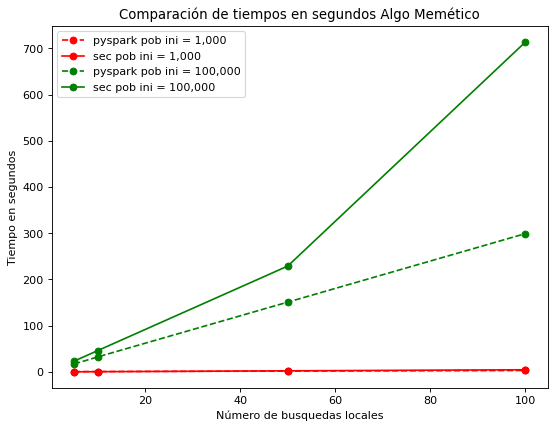

In [7]:


N=1000
itera=[5,10,50,100]
#fitness original_1000 = 667
tiempo_pyspark_1000 = [.631,.795, 1.82,3.09]
tiempo_secuencial_1000 = [.262,.481, 2.38,4.67]
fitness_pyspark_1000 = [648.5,613.5,549,483.5]
fitness_secuencial_1000 =[633, 579,541,485]

N = 100000 
#fintess_original_100000 = 574
tiempo_pyspark_100000 = [17.2, 32.6, 151,299]
tiempo_secuencial_100000 = [23.4, 46.3, 229,713]
fitness_pyspark_100000 = [532.5, 525.0, 450,420]
fitness_secuencial_100000 =[556,518, 454,430]


figure(figsize=(8, 6), dpi=80)

plt.plot(itera, tiempo_pyspark_1000,"o",color="red", linestyle='dashed', label = "pyspark pob ini = 1,000")




plt.plot(itera, tiempo_secuencial_1000,"o",color="red",  linestyle="solid",label = "sec pob ini = 1,000")
plt.plot(itera, tiempo_pyspark_100000,"o",color="green", linestyle='dashed', label = "pyspark pob ini = 100,000")
plt.plot(itera, tiempo_secuencial_100000,"o",color="green",  linestyle="solid",label = "sec pob ini = 100,000")
plt.title("Comparación de tiempos en segundos Algo Memético")
plt.xlabel('Número de busquedas locales')
plt.ylabel('Tiempo en segundos')
plt.legend()

plt.savefig('memetico_tiempo.png')
plt.show()

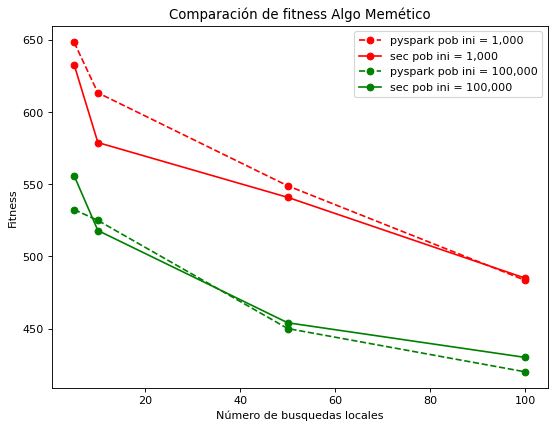

In [9]:
figure(figsize=(8, 6), dpi=80)
plt.plot(itera, fitness_pyspark_1000,"o",color="red", linestyle='dashed', label = "pyspark pob ini = 1,000")




plt.plot(itera, fitness_secuencial_1000,"o",color="red",  linestyle="solid",label = "sec pob ini = 1,000")
plt.plot(itera, fitness_pyspark_100000,"o",color="green", linestyle='dashed', label = "pyspark pob ini = 100,000")
plt.plot(itera, fitness_secuencial_100000,"o",color="green",  linestyle="solid",label = "sec pob ini = 100,000")
plt.title("Comparación de fitness Algo Memético")
plt.xlabel('Número de busquedas locales')
plt.ylabel('Fitness')
plt.legend()

plt.savefig('memetico_fitness.png')
plt.show()